In [1]:
import pandas as pd
import numpy as np
import os

In [23]:
df = pd.read_csv('dane_lista3.csv')
df['Transaction ID'] = df['Transaction ID'].astype(str)
df['Item'] = df['Item'].astype(str)
df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce')
df['Price Per Unit'] = pd.to_numeric(df['Price Per Unit'], errors='coerce')
df['Total Spent'] = pd.to_numeric(df['Total Spent'], errors='coerce')
df['Payment Method'] = df['Payment Method'].astype(str)
df['Location'] = df['Location'].astype(str)
df['Transaction Date'] = pd.to_datetime(df['Transaction Date'], errors='coerce')
df.head()

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1961373,Coffee,2.0,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,TXN_4977031,Cake,4.0,3.0,12.0,Cash,In-store,2023-05-16
2,TXN_4271903,Cookie,4.0,1.0,NaN,Credit Card,In-store,2023-07-19
3,TXN_7034554,Salad,2.0,5.0,10.0,UNKNOWN,UNKNOWN,2023-04-27
4,TXN_3160411,Coffee,2.0,2.0,4.0,Digital Wallet,In-store,2023-06-11


In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
from IPython.display import display, HTML, Markdown
import warnings
warnings.filterwarnings('ignore')

def load_data(data_str=None, file_path=None):
    if data_str:
        lines = data_str.strip().split('\n')
        import io
        data = pd.read_csv(io.StringIO('\n'.join(lines)))
    elif file_path:
        data = pd.read_csv(file_path)
    else:
        raise ValueError("Należy podać albo string z danymi albo ścieżkę do pliku.")
    data['Transaction ID'] = data['Transaction ID'].astype(str)
    data['Item'] = data['Item'].astype(str)
    data['Quantity'] = pd.to_numeric(data['Quantity'], errors='coerce')
    data['Price Per Unit'] = pd.to_numeric(data['Price Per Unit'], errors='coerce')
    data['Total Spent'] = pd.to_numeric(data['Total Spent'], errors='coerce')
    data['Payment Method'] = data['Payment Method'].astype(str)
    data['Location'] = data['Location'].astype(str)
    data['Transaction Date'] = pd.to_datetime(data['Transaction Date'], errors='coerce')
    #data = data.replace('', np.nan).replace('ERROR', np.nan).replace('UNKNOWN', np.nan)
    return data

def generate_overview(df):
    print("=" * 80)
    print("PRZEGLĄD DANYCH")
    print("=" * 80)
    print(f"Liczba rekordów: {len(df)}")
    print(f"Liczba zmiennych: {len(df.columns)}")
    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    datetime_cols = df.select_dtypes(include=['datetime64']).columns.tolist()
    print(f"Liczba zmiennych liczbowych: {len(numeric_cols)}")
    print(f"Liczba zmiennych kategorycznych: {len(categorical_cols)}")
    print(f"Liczba zmiennych czasowych: {len(datetime_cols)}")
    missing_values = df.isnull().sum().sum()
    missing_percent = missing_values / (df.shape[0] * df.shape[1]) * 100
    print(f"Całkowita liczba brakujących wartości: {missing_values}")
    print(f"Procent brakujących wartości: {missing_percent:.2f}%")
    memory_usage = df.memory_usage(deep=True).sum()
    units = ['B', 'KB', 'MB', 'GB']
    size_index = 0
    while memory_usage > 1024 and size_index < len(units) - 1:
        memory_usage /= 1024
        size_index += 1
    print(f"Rozmiar w pamięci: {memory_usage:.2f} {units[size_index]}")
    print("\nTypy danych:")
    for col in df.columns:
        print(f"- {col}: {df[col].dtype}")
    print("\n")

In [40]:


def analyze_categorical(df, column):
    print(f"Analiza zmiennej: {column}")
    print("-" * 50)
    unique_values = df[column].nunique()
    missing_values = df[column].isnull().sum()
    missing_percent = missing_values / len(df) * 100
    print(f"Liczba unikalnych wartości: {unique_values}")
    print(f"Brakujące wartości: {missing_values} ({missing_percent:.2f}%)")
    value_counts = df[column].value_counts()
    print("\nNajczęstsze wartości:")
    for val, count in value_counts.head(10).items():
        percent = count / len(df) * 100
        print(f"- {val}: {count} ({percent:.2f}%)")
    plt.figure(figsize=(10, 6))
    if unique_values <= 15:
        ax = sns.countplot(y=column, data=df, order=value_counts.index[:15])
        plt.title(f"Rozkład wartości dla {column}")
        plt.xlabel("Liczba wystąpień")
        plt.ylabel(column)
        for i, v in enumerate(value_counts.values[:15]):
            ax.text(v + 0.1, i, str(v), va='center')
    else:
        plt.figure(figsize=(10, 6))
        plt.hist(df[column].dropna().astype(str).map(len), bins=20)
        plt.title(f"Rozkład długości wartości dla {column}")
        plt.xlabel("Długość wartości")
        plt.ylabel("Liczba wystąpień")
    plt.tight_layout()
    plt.show()
    print("\n")

def analyze_numeric(df, column):
    print(f"Analiza zmiennej: {column}")
    print("-" * 50)
    data = df[column].dropna()
    stats = {
        "Liczba wartości": len(data),
        "Brakujące wartości": df[column].isnull().sum(),
        "Procent brakujących": df[column].isnull().sum() / len(df) * 100,
        "Średnia": data.mean(),
        "Odchylenie standardowe": data.std(),
        "Minimum": data.min(),
        "25%": data.quantile(0.25),
        "Mediana": data.median(),
        "75%": data.quantile(0.75),
        "Maximum": data.max(),
        "Skośność": data.skew(),
        "Kurtoza": data.kurt(),
        "Zeros": (data == 0).sum(),
        "Procent zeros": (data == 0).sum() / len(data) * 100 if len(data) > 0 else 0,
        "Ujemne wartości": (data < 0).sum(),
        "Procent ujemnych": (data < 0).sum() / len(data) * 100 if len(data) > 0 else 0
    }
    for key, value in stats.items():
        if isinstance(value, (int, np.integer)):
            print(f"{key}: {value}")
        else:
            print(f"{key}: {value:.4f}")
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 2, 1)
    sns.histplot(data, kde=True)
    plt.title(f"Histogram dla {column}")
    plt.subplot(2, 2, 2)
    sns.boxplot(x=data)
    plt.title(f"Box plot dla {column}")
    plt.subplot(2, 2, 3)
    from scipy import stats as scipy_stats
    scipy_stats.probplot(data, plot=plt)
    plt.title(f"Wykres Q-Q dla {column}")
    plt.subplot(2, 2, 4)
    sns.violinplot(x=data)
    plt.title(f"Violin plot dla {column}")
    plt.tight_layout()
    plt.show()
    print("\n")

def analyze_datetime(df, column):
    print(f"Analiza zmiennej: {column}")
    print("-" * 50)
    data = df[column].dropna()
    stats = {
        "Liczba wartości": len(data),
        "Brakujące wartości": df[column].isnull().sum(),
        "Procent brakujących": df[column].isnull().sum() / len(df) * 100,
        "Najwcześniejsza data": data.min(),
        "Najpóźniejsza data": data.max(),
        "Zakres (dni)": (data.max() - data.min()).days
    }
    for key, value in stats.items():
        print(f"{key}: {value}")
    if len(data) > 0:
        temp_df = pd.DataFrame({
            'rok': data.dt.year,
            'miesiąc': data.dt.month,
            'dzień': data.dt.day,
            'dzień tygodnia': data.dt.dayofweek
        })
        plt.figure(figsize=(15, 10))
        plt.subplot(2, 2, 1)
        sns.countplot(x='miesiąc', data=temp_df, order=sorted(temp_df['miesiąc'].unique()))
        plt.title(f"Rozkład po miesiącach dla {column}")
        plt.xlabel("Miesiąc")
        plt.ylabel("Liczba")
        plt.subplot(2, 2, 2)
        days = ['Poniedziałek', 'Wtorek', 'Środa', 'Czwartek', 'Piątek', 'Sobota', 'Niedziela']
        day_map = {i: day for i, day in enumerate(days)}
        sns.countplot(x='dzień tygodnia', data=temp_df, order=sorted(temp_df['dzień tygodnia'].unique()))
        plt.xticks(range(7), [day_map.get(i, i) for i in range(7)], rotation=45)
        plt.title(f"Rozkład po dniach tygodnia dla {column}")
        plt.xlabel("Dzień tygodnia")
        plt.ylabel("Liczba")
        plt.subplot(2, 1, 2)
        plt.plot(pd.Series(data.values).sort_values())
        plt.title(f"Rozkład w czasie dla {column}")
        plt.xlabel("Indeks")
        plt.ylabel("Data")
        plt.tight_layout()
        plt.show()
    print("\n")

In [41]:

def analyze_correlations(df):
    print("=" * 80)
    print("KORELACJE MIĘDZY ZMIENNYMI")
    print("=" * 80)
    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    if len(numeric_cols) >= 2:
        corr_matrix = df[numeric_cols].corr()
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
        plt.title("Macierz korelacji dla zmiennych liczbowych")
        plt.tight_layout()
        plt.show()
        print("\nNajsilniejsze korelacje:")
        corr_pairs = []
        for i in range(len(numeric_cols)):
            for j in range(i+1, len(numeric_cols)):
                col1, col2 = numeric_cols[i], numeric_cols[j]
                corr = corr_matrix.loc[col1, col2]
                corr_pairs.append((col1, col2, corr))
        corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
        for col1, col2, corr in corr_pairs:
            print(f"- {col1} i {col2}: {corr:.4f}")
    else:
        print("Za mało zmiennych liczbowych do analizy korelacji.")
    print('\n')

def analyze_missing_values(df):
    print("=" * 80)
    print("ANALIZA BRAKUJĄCYCH WARTOŚCI")
    print("=" * 80)
    missing = df.isnull().sum()
    missing_percent = missing / len(df) * 100
    missing_df = pd.DataFrame({
        'Liczba brakujących': missing,
        'Procent brakujących': missing_percent
    }).sort_values('Procent brakujących', ascending=False)
    print(missing_df)
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x=missing_df.index, y='Procent brakujących', data=missing_df)
    plt.title("Procent brakujących wartości w kolumnach")
    plt.xlabel("Kolumna")
    plt.ylabel("Procent brakujących wartości")
    plt.xticks(rotation=45)
    for i, v in enumerate(missing_df['Procent brakujących']):
        ax.text(i, v + 0.5, f"{v:.2f}%", ha='center')
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(12, 6))
    sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
    plt.title("Wzory brakujących wartości")
    plt.xlabel("Kolumna")
    plt.ylabel("Rekord")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    print('\n')

PRZEGLĄD DANYCH
Liczba rekordów: 10002
Liczba zmiennych: 8
Liczba zmiennych liczbowych: 3
Liczba zmiennych kategorycznych: 4
Liczba zmiennych czasowych: 1
Całkowita liczba brakujących wartości: 1978
Procent brakujących wartości: 2.47%
Rozmiar w pamięci: 2.77 MB

Typy danych:
- Transaction ID: object
- Item: object
- Quantity: float64
- Price Per Unit: float64
- Total Spent: float64
- Payment Method: object
- Location: object
- Transaction Date: datetime64[ns]


ANALIZA POSZCZEGÓLNYCH ZMIENNYCH


Analiza zmiennej: Transaction ID
--------------------------------------------------
Liczba unikalnych wartości: 9999
Brakujące wartości: 0 (0.00%)

Najczęstsze wartości:
- TXN_8859035: 3 (0.03%)
- TXN_1108663: 2 (0.02%)
- TXN_1961373: 1 (0.01%)
- TXN_5308047: 1 (0.01%)
- TXN_1228927: 1 (0.01%)
- TXN_6486912: 1 (0.01%)
- TXN_3447069: 1 (0.01%)
- TXN_8219298: 1 (0.01%)
- TXN_1010950: 1 (0.01%)
- TXN_6376329: 1 (0.01%)


<Figure size 1000x600 with 0 Axes>

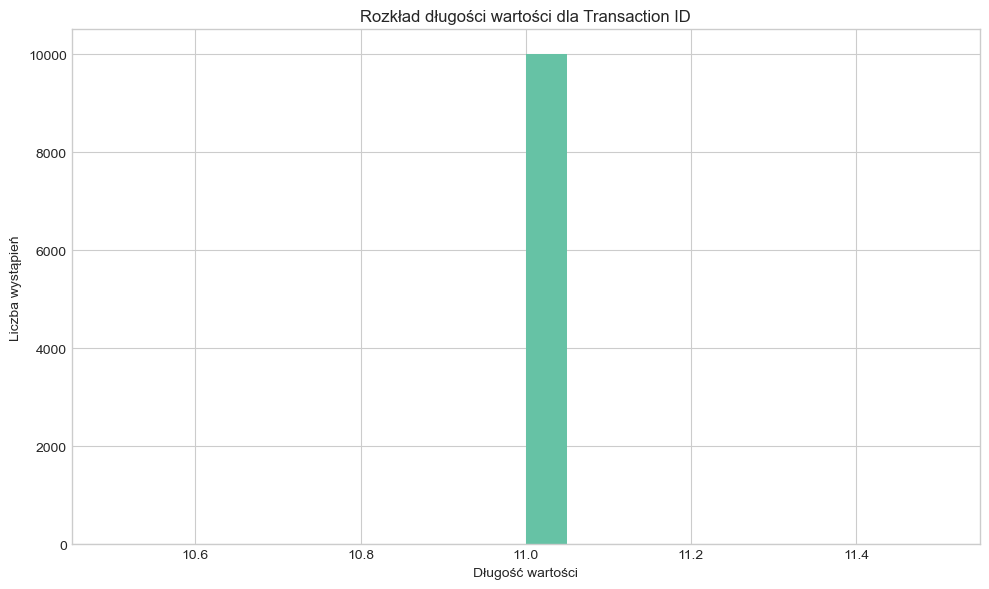





Analiza zmiennej: Item
--------------------------------------------------
Liczba unikalnych wartości: 12
Brakujące wartości: 0 (0.00%)

Najczęstsze wartości:
- Juice: 1171 (11.71%)
- Coffee: 1164 (11.64%)
- Salad: 1148 (11.48%)
- Cake: 1141 (11.41%)
- Sandwich: 1131 (11.31%)
- Smoothie: 1096 (10.96%)
- Cookie: 1092 (10.92%)
- Tea: 1089 (10.89%)
- UNKNOWN: 344 (3.44%)
- nan: 333 (3.33%)


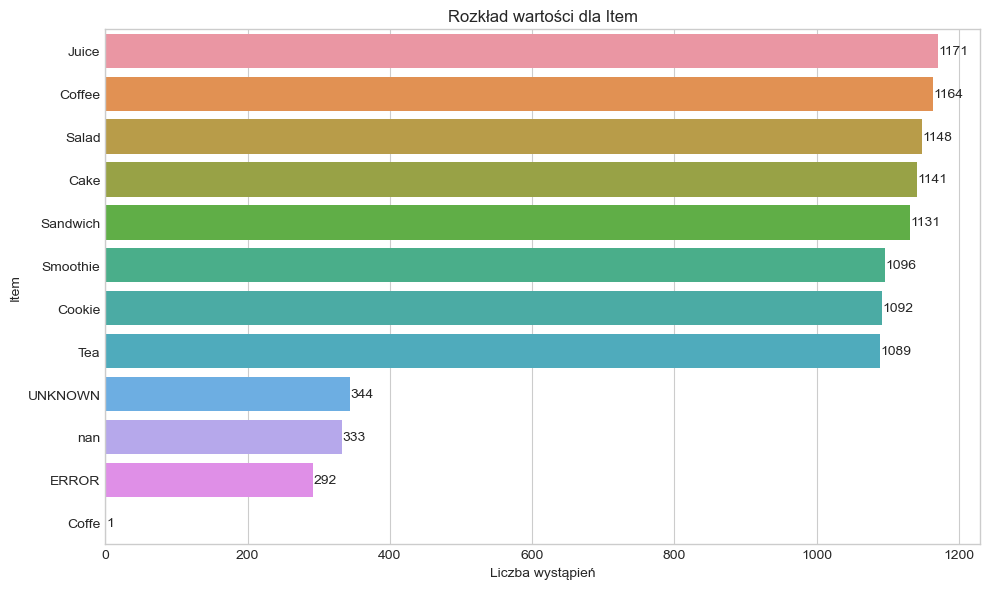





Analiza zmiennej: Quantity
--------------------------------------------------
Liczba wartości: 9523
Brakujące wartości: 479
Procent brakujących: 4.7890
Średnia: 3.0384
Odchylenie standardowe: 1.7328
Minimum: -2.0000
25%: 2.0000
Mediana: 3.0000
75%: 4.0000
Maximum: 100.0000
Skośność: 18.3846
Kurtoza: 1027.9461
Zeros: 0
Procent zeros: 0.0000
Ujemne wartości: 1
Procent ujemnych: 0.0105


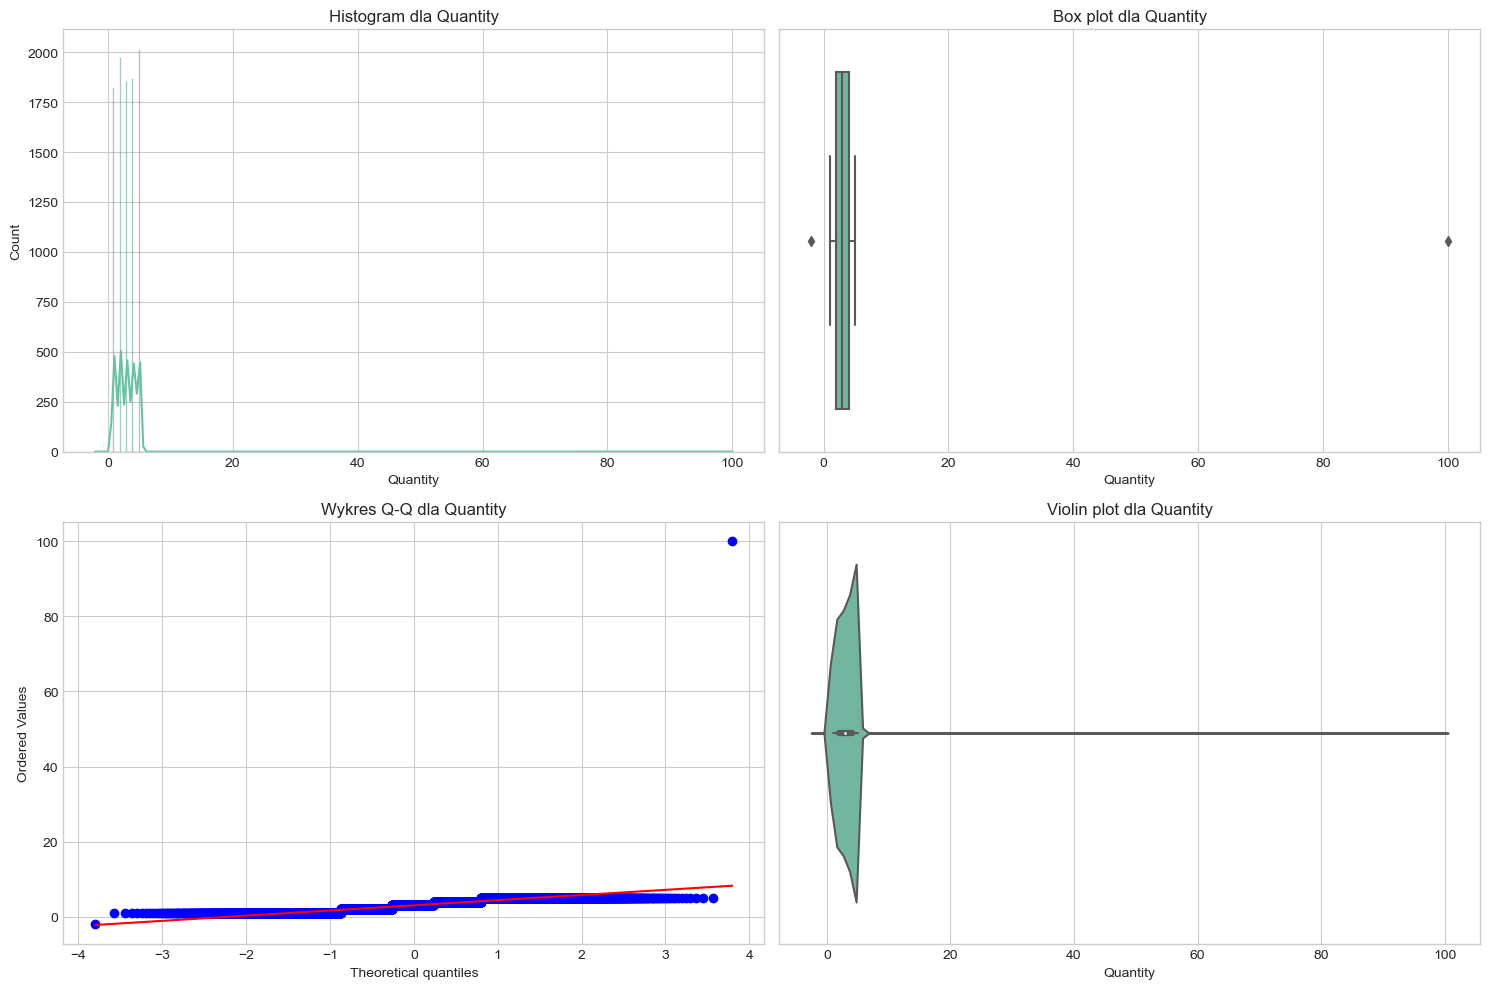





Analiza zmiennej: Price Per Unit
--------------------------------------------------
Liczba wartości: 9469
Brakujące wartości: 533
Procent brakujących: 5.3289
Średnia: 2.9500
Odchylenie standardowe: 1.2783
Minimum: 1.0000
25%: 2.0000
Mediana: 3.0000
75%: 4.0000
Maximum: 5.0000
Skośność: 0.0046
Kurtoza: -1.1553
Zeros: 0
Procent zeros: 0.0000
Ujemne wartości: 0
Procent ujemnych: 0.0000


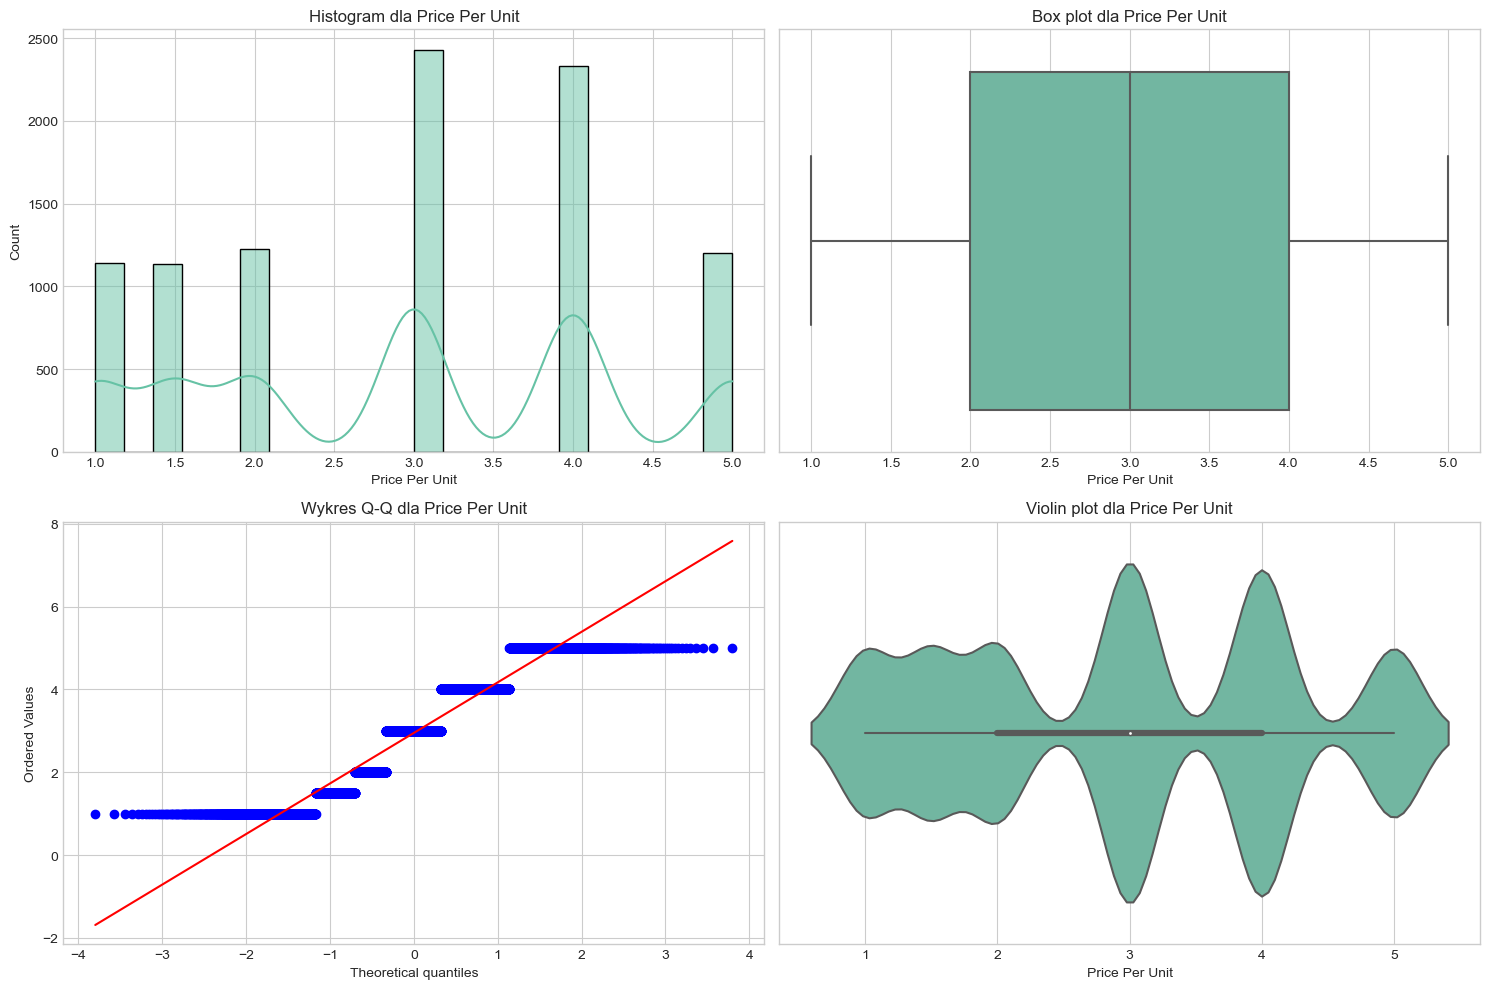





Analiza zmiennej: Total Spent
--------------------------------------------------
Liczba wartości: 9500
Brakujące wartości: 502
Procent brakujących: 5.0190
Średnia: 8.9244
Odchylenie standardowe: 6.0093
Minimum: 1.0000
25%: 4.0000
Mediana: 8.0000
75%: 12.0000
Maximum: 25.0000
Skośność: 0.8239
Kurtoza: -0.1446
Zeros: 0
Procent zeros: 0.0000
Ujemne wartości: 0
Procent ujemnych: 0.0000


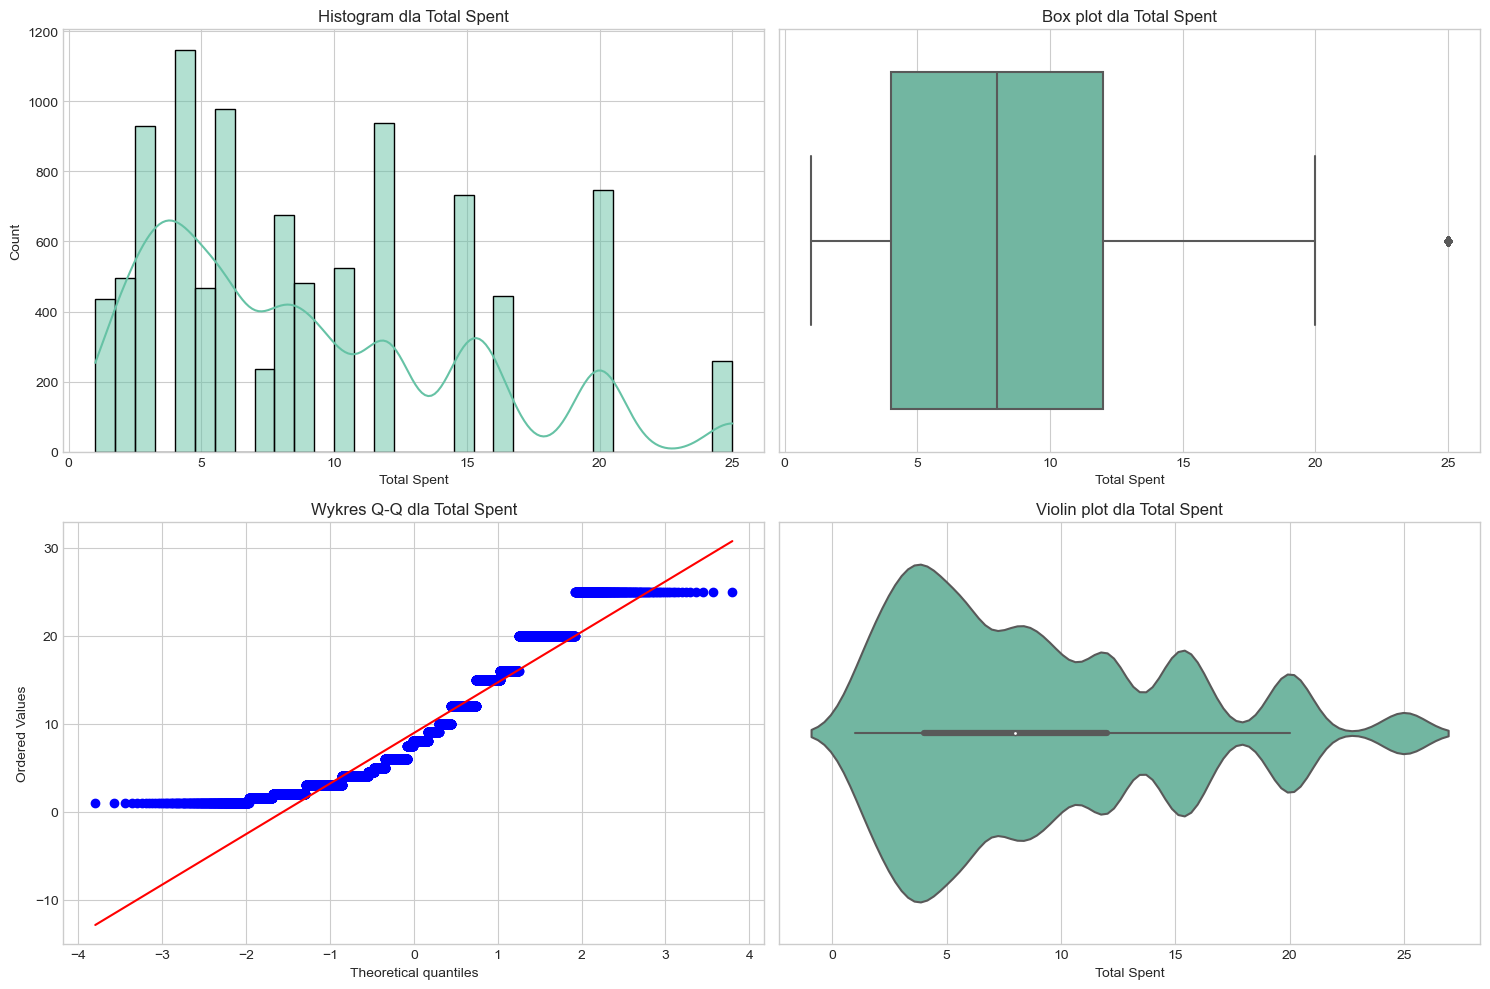





Analiza zmiennej: Payment Method
--------------------------------------------------
Liczba unikalnych wartości: 8
Brakujące wartości: 0 (0.00%)

Najczęstsze wartości:
- nan: 2579 (25.78%)
- Digital Wallet: 2292 (22.92%)
- Credit Card: 2272 (22.72%)
- Cash: 2258 (22.58%)
- ERROR: 306 (3.06%)
- UNKNOWN: 293 (2.93%)
- Digital Walle: 1 (0.01%)
- CreditCard: 1 (0.01%)


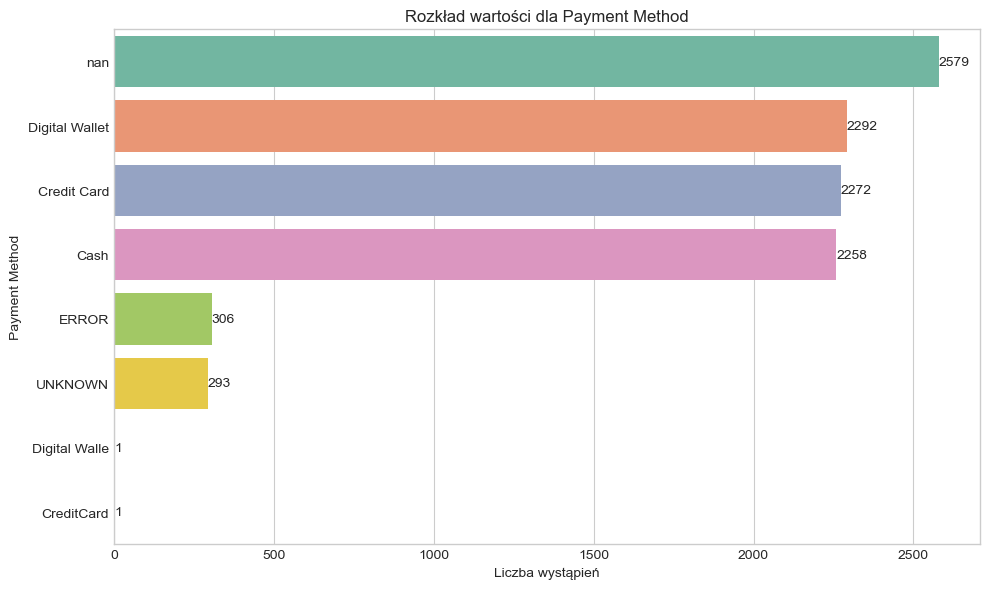





Analiza zmiennej: Location
--------------------------------------------------
Liczba unikalnych wartości: 5
Brakujące wartości: 0 (0.00%)

Najczęstsze wartości:
- nan: 3265 (32.64%)
- Takeaway: 3024 (30.23%)
- In-store: 3017 (30.16%)
- ERROR: 358 (3.58%)
- UNKNOWN: 338 (3.38%)


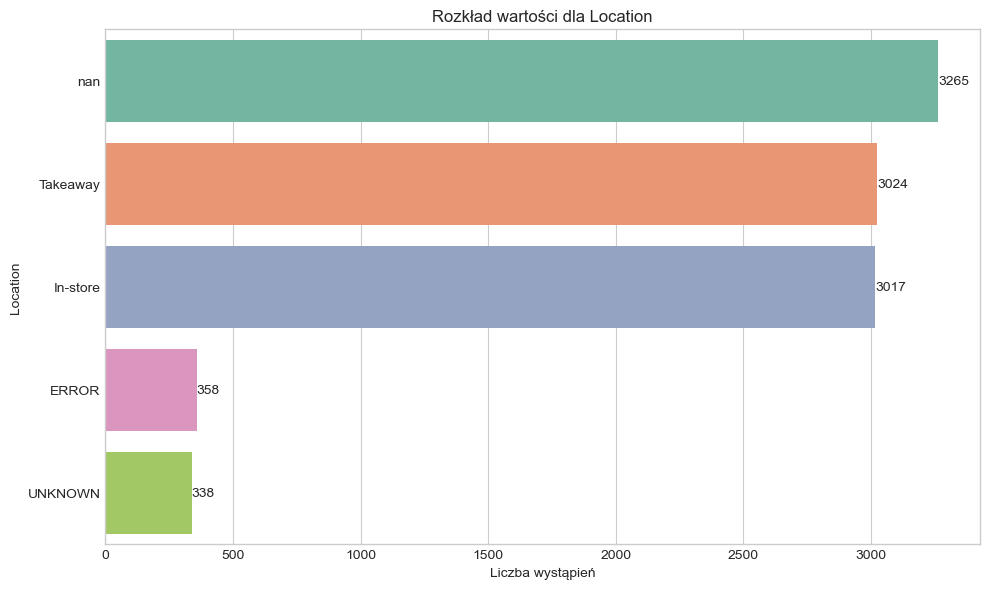





Analiza zmiennej: Transaction Date
--------------------------------------------------
Liczba wartości: 9538
Brakujące wartości: 464
Procent brakujących: 4.639072185562887
Najwcześniejsza data: 2023-01-01 00:00:00
Najpóźniejsza data: 2026-01-07 00:00:00
Zakres (dni): 1102


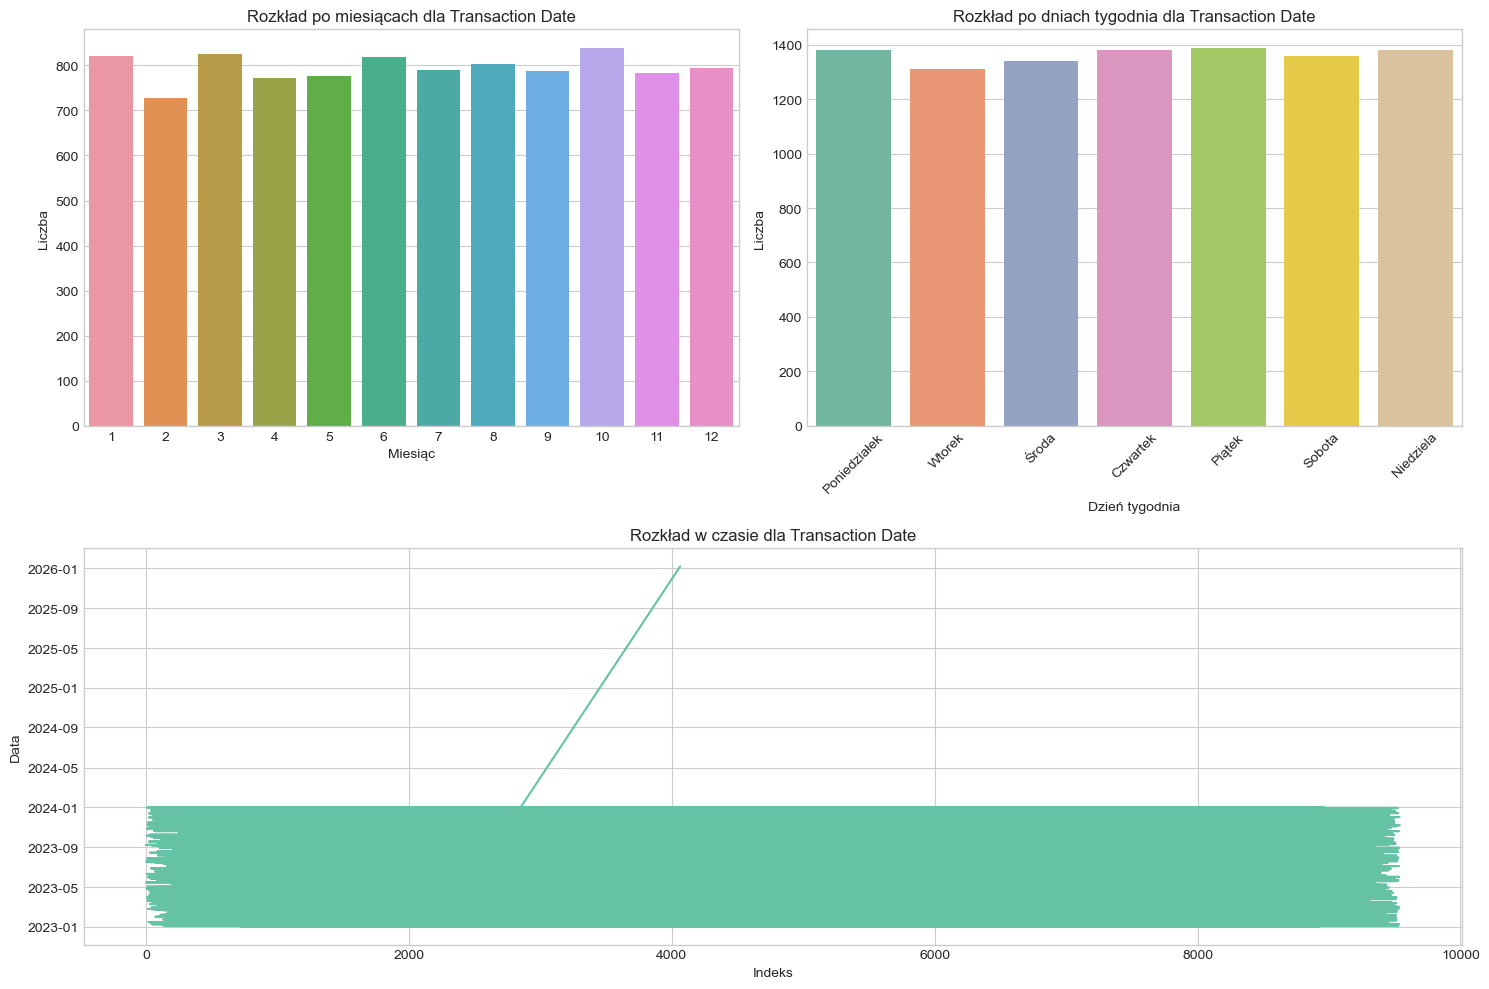



KORELACJE MIĘDZY ZMIENNYMI


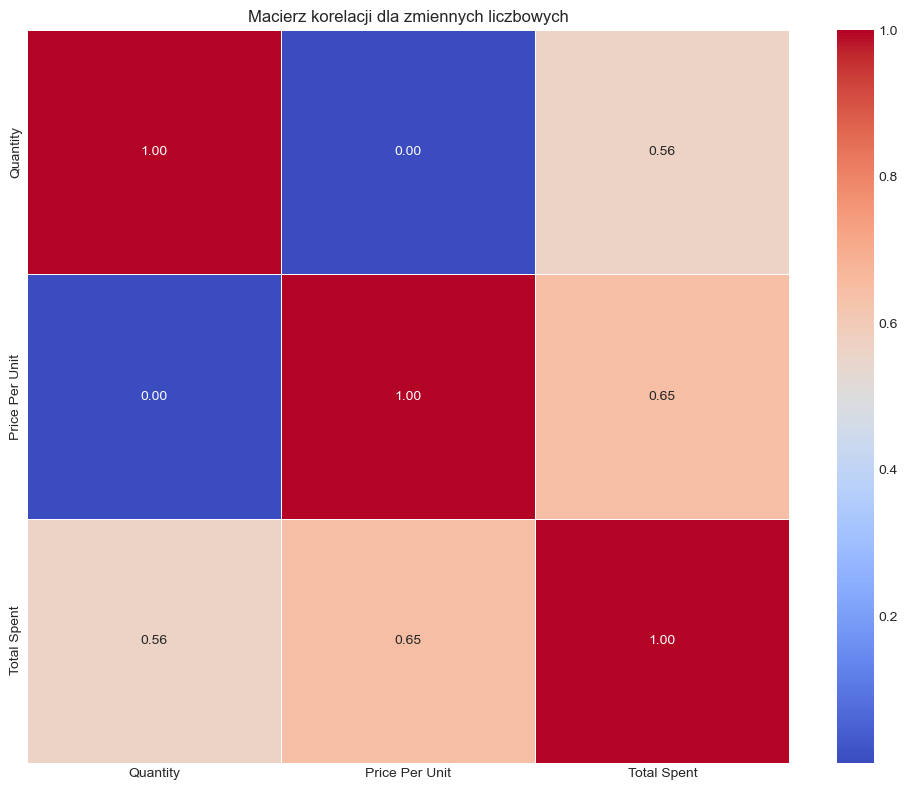


Najsilniejsze korelacje:
- Price Per Unit i Total Spent: 0.6475
- Quantity i Total Spent: 0.5648
- Quantity i Price Per Unit: 0.0004


ANALIZA BRAKUJĄCYCH WARTOŚCI
                  Liczba brakujących  Procent brakujących
Price Per Unit                   533             5.328934
Total Spent                      502             5.018996
Quantity                         479             4.789042
Transaction Date                 464             4.639072
Transaction ID                     0             0.000000
Item                               0             0.000000
Payment Method                     0             0.000000
Location                           0             0.000000


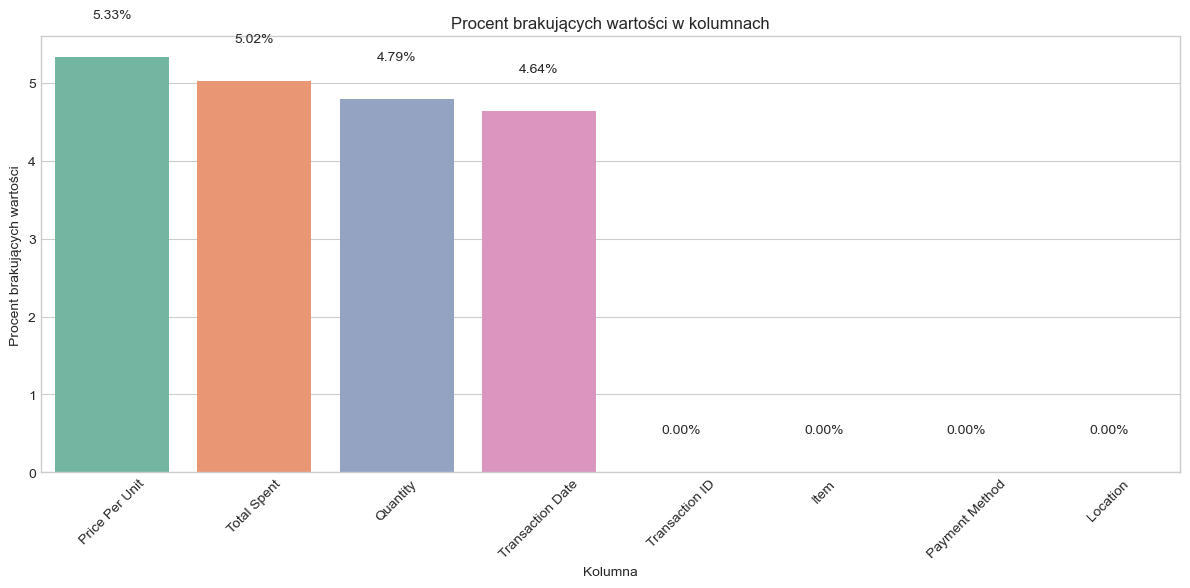

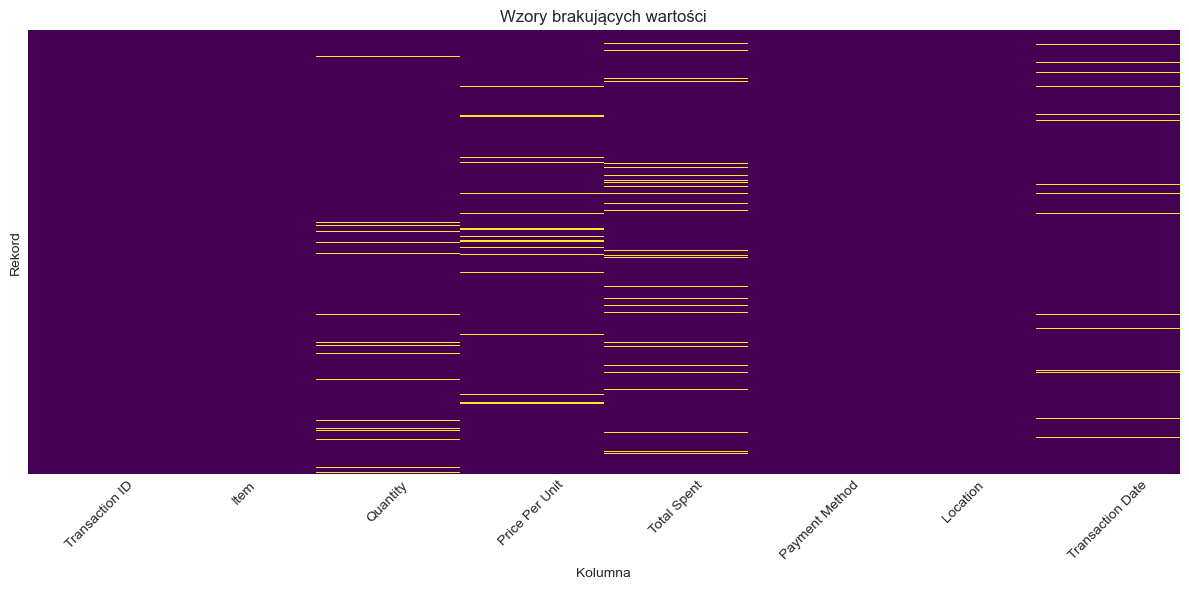



ANALIZA SPÓJNOŚCI DANYCH
Niespójności w Total Spent: 1 (0.01%)

Przykłady niespójności:
     Transaction ID  Quantity  Price Per Unit  Total Spent  Oczekiwane Total  \
7788    TXN_7445257     100.0             2.0          2.0             200.0   

      Różnica  
7788    198.0  


PROBLEMY Z JAKOŚCIĄ DANYCH
1. Kolumna 'Quantity' zawiera 479 (4.79%) brakujących wartości.
2. Kolumna 'Price Per Unit' zawiera 533 (5.33%) brakujących wartości.
3. Kolumna 'Total Spent' zawiera 502 (5.02%) brakujących wartości.
4. Kolumna 'Transaction Date' zawiera 464 (4.64%) brakujących wartości.
5. Wykryto 1 niespójności między 'Quantity' * 'Price Per Unit' a 'Total Spent'.
6. Znaleziono 2 zduplikowanych rekordów.
7. Kolumna 'Quantity' zawiera 2 (0.02%) wartości odstających.
8. Kolumna 'Total Spent' zawiera 259 (2.59%) wartości odstających.


PODSUMOWANIE I REKOMENDACJE
Nie znaleziono istotnych problemów wymagających natychmiastowej uwagi.

Analiza zakończona.


In [42]:



def analyze_data_consistency(df):
    print("=" * 80)
    print("ANALIZA SPÓJNOŚCI DANYCH")
    print("=" * 80)
    if all(col in df.columns for col in ['Quantity', 'Price Per Unit', 'Total Spent']):
        df_check = df.dropna(subset=['Quantity', 'Price Per Unit', 'Total Spent'])
        expected_total = df_check['Quantity'] * df_check['Price Per Unit']
        diff = abs(expected_total - df_check['Total Spent'])
        inconsistent = diff > 0.01
        inconsistent_count = inconsistent.sum()
        inconsistent_percent = inconsistent.mean() * 100
        print(f"Niespójności w Total Spent: {inconsistent_count} ({inconsistent_percent:.2f}%)")
        if inconsistent_count > 0:
            print("\nPrzykłady niespójności:")
            inconsistent_df = df_check[inconsistent].head(5)
            inconsistent_df['Oczekiwane Total'] = expected_total[inconsistent].head(5)
            inconsistent_df['Różnica'] = diff[inconsistent].head(5)
            print(inconsistent_df[['Transaction ID', 'Quantity', 'Price Per Unit', 'Total Spent', 'Oczekiwane Total', 'Różnica']])
    print('\n')

def generate_column_reports(df):
    print("=" * 80)
    print("ANALIZA POSZCZEGÓLNYCH ZMIENNYCH")
    print("=" * 80)
    for column in df.columns:
        print("\n")
        if pd.api.types.is_numeric_dtype(df[column]):
            analyze_numeric(df, column)
        elif pd.api.types.is_datetime64_dtype(df[column]):
            analyze_datetime(df, column)
        else:
            analyze_categorical(df, column)

def detect_data_quality_issues(df):
    print("=" * 80)
    print("PROBLEMY Z JAKOŚCIĄ DANYCH")
    print("=" * 80)
    issues = []
    for col in df.columns:
        missing = df[col].isnull().sum()
        if missing > 0:
            missing_percent = missing / len(df) * 100
            issues.append(f"Kolumna '{col}' zawiera {missing} ({missing_percent:.2f}%) brakujących wartości.")
    if all(col in df.columns for col in ['Quantity', 'Price Per Unit', 'Total Spent']):
        df_check = df.dropna(subset=['Quantity', 'Price Per Unit', 'Total Spent'])
        expected_total = df_check['Quantity'] * df_check['Price Per Unit']
        diff = abs(expected_total - df_check['Total Spent'])
        inconsistent = diff > 0.01
        inconsistent_count = inconsistent.sum()
        if inconsistent_count > 0:
            issues.append(f"Wykryto {inconsistent_count} niespójności między 'Quantity' * 'Price Per Unit' a 'Total Spent'.")
    duplicates = df.duplicated().sum()
    if duplicates > 0:
        issues.append(f"Znaleziono {duplicates} zduplikowanych rekordów.")
    for col in df.select_dtypes(include=np.number).columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
        if len(outliers) > 0:
            outlier_percent = len(outliers) / len(df) * 100
            issues.append(f"Kolumna '{col}' zawiera {len(outliers)} ({outlier_percent:.2f}%) wartości odstających.")
    if issues:
        for i, issue in enumerate(issues, 1):
            print(f"{i}. {issue}")
    else:
        print("Nie wykryto znaczących problemów z jakością danych.")
    print('\n')

def generate_data_profiling_report(data_str=None, file_path=None):
    df = load_data(data_str, file_path)
    plt.style.use('seaborn-v0_8-whitegrid')
    sns.set_palette("Set2")
    generate_overview(df)
    generate_column_reports(df)
    analyze_correlations(df)
    analyze_missing_values(df)
    analyze_data_consistency(df)
    detect_data_quality_issues(df)
    print("=" * 80)
    print("PODSUMOWANIE I REKOMENDACJE")
    print("=" * 80)
    recommendations = []
    missing_cols = df.columns[df.isnull().mean() > 0.2].tolist()
    if missing_cols:
        recommendations.append(f"Rozważ usunięcie lub imputację kolumn z dużą liczbą brakujących wartości: {', '.join(missing_cols)}")
    numeric_cols = df.select_dtypes(include=np.number).columns
    for col in numeric_cols:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
        if len(outliers) / len(df) > 0.05:
            recommendations.append(f"Rozważ obsługę wartości odstających w kolumnie '{col}'.")
    if recommendations:
        print("Na podstawie analizy danych, sugerowane są następujące działania:")
        for i, rec in enumerate(recommendations, 1):
            print(f"{i}. {rec}")
    else:
        print("Nie znaleziono istotnych problemów wymagających natychmiastowej uwagi.")
    print("\nAnaliza zakończona.")

generate_data_profiling_report(file_path="dane_lista3.csv")
